# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

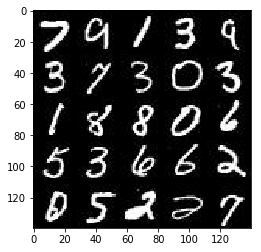

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

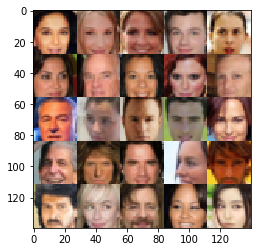

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                (None, image_width, image_height, image_channels),
                                name='inputs_real')
    inputs_z = tf.placeholder(tf.float32,
                             (None, z_dim),
                             name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        h1 = tf.maximum(alpha*h1, h1)
        
        h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(alpha*h2, h2)
        
        h3 = tf.layers.conv2d(h2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(alpha*h3, h3)
        
        flat = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        stddev = 0.02
        
        h1 = tf.layers.dense(z, 7*7*256)
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha*h2, h2)
        
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha*h3, h3)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch_counter = 0
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    learn_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    learn_rate: learning_rate
                })
                
                batch_counter += 1
                
                if (batch_counter%10 == 0):
                    train_loss_d = sess.run(d_loss, {
                        input_z: batch_z, input_real: batch_images
                    })
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i+1, epochs),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                    
                if (batch_counter%100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.9202
Epoch 1/2... Discriminator Loss: 2.1854... Generator Loss: 3.0459
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.7703
Epoch 1/2... Discriminator Loss: 1.0656... Generator Loss: 0.8969
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 2.0152
Epoch 1/2... Discriminator Loss: 1.6704... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 1.2133
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 1.5161


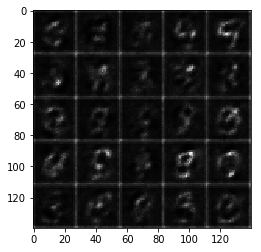

Epoch 1/2... Discriminator Loss: 1.1149... Generator Loss: 1.4005
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 1.3219
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 2.4280
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 1.4779
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.1128... Generator Loss: 0.7955
Epoch 1/2... Discriminator Loss: 0.8763... Generator Loss: 1.3723


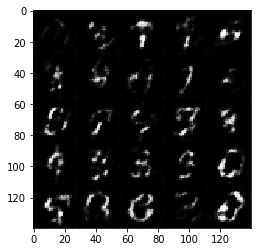

Epoch 1/2... Discriminator Loss: 1.1455... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 0.8396... Generator Loss: 1.2668
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 1.1522... Generator Loss: 2.6190
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 1.3623
Epoch 1/2... Discriminator Loss: 0.9789... Generator Loss: 2.2477
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 0.9376
Epoch 1/2... Discriminator Loss: 0.8384... Generator Loss: 1.8241


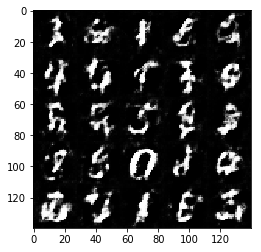

Epoch 1/2... Discriminator Loss: 0.8889... Generator Loss: 1.1967
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 0.9087... Generator Loss: 1.0569
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.4366
Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.5716
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 1.8515
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.5637
Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.7228... Generator Loss: 2.6491
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.5893


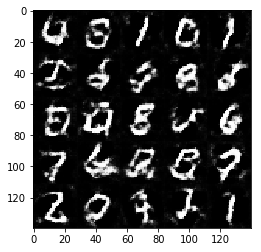

Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 2.1681
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.9551
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.2973
Epoch 1/2... Discriminator Loss: 1.0707... Generator Loss: 1.6219
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 1.0370
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 1.8034
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 1.3288
Epoch 1/2... Discriminator Loss: 0.9790... Generator Loss: 1.0004


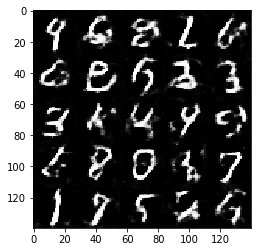

Epoch 1/2... Discriminator Loss: 0.9214... Generator Loss: 1.4907
Epoch 1/2... Discriminator Loss: 0.9012... Generator Loss: 1.1254
Epoch 1/2... Discriminator Loss: 0.9171... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 1.0048... Generator Loss: 0.9389
Epoch 1/2... Discriminator Loss: 0.9177... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.9942... Generator Loss: 1.5963
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6157
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.2845


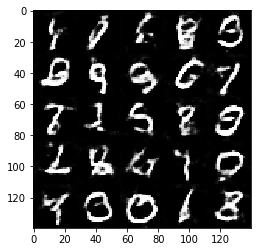

Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.4202
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0295
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.1955
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.7220
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 0.9493
Epoch 1/2... Discriminator Loss: 0.9240... Generator Loss: 1.0683
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 1.2695
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.8173


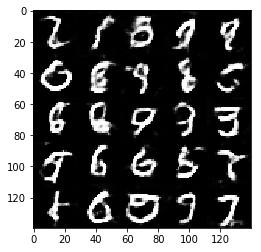

Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 0.9546... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 1.0245
Epoch 1/2... Discriminator Loss: 1.5385... Generator Loss: 2.9704
Epoch 1/2... Discriminator Loss: 0.8663... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 1.9198
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.2586


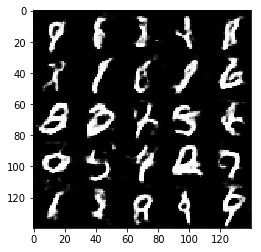

Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.6092
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 1.8301
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 1.1908
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 0.8232... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 0.8603... Generator Loss: 1.3058
Epoch 1/2... Discriminator Loss: 3.9467... Generator Loss: 5.0356
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.5132


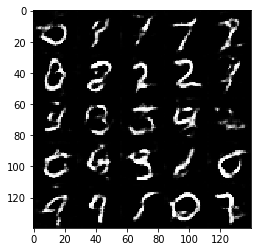

Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 1.3539
Epoch 1/2... Discriminator Loss: 0.8250... Generator Loss: 1.7094
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 0.9217... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 0.8369... Generator Loss: 1.2956
Epoch 2/2... Discriminator Loss: 0.8326... Generator Loss: 1.5199
Epoch 2/2... Discriminator Loss: 0.7841... Generator Loss: 1.4231
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.6898
Epoch 2/2... Discriminator Loss: 0.8616... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 0.8849... Generator Loss: 1.0639


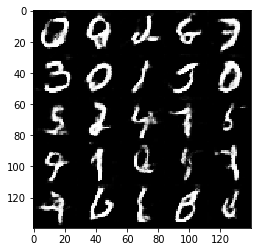

Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 1.3703... Generator Loss: 1.4268
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 0.9672
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.2641
Epoch 2/2... Discriminator Loss: 0.9008... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.8710... Generator Loss: 1.4260
Epoch 2/2... Discriminator Loss: 0.8859... Generator Loss: 0.9988
Epoch 2/2... Discriminator Loss: 0.8179... Generator Loss: 1.3936
Epoch 2/2... Discriminator Loss: 0.9552... Generator Loss: 0.9898
Epoch 2/2... Discriminator Loss: 1.4554... Generator Loss: 0.5045


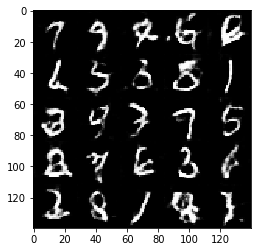

Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.8664
Epoch 2/2... Discriminator Loss: 0.9534... Generator Loss: 0.9872
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 1.1072
Epoch 2/2... Discriminator Loss: 0.7645... Generator Loss: 1.5107
Epoch 2/2... Discriminator Loss: 0.8575... Generator Loss: 1.1673
Epoch 2/2... Discriminator Loss: 0.7772... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.2226
Epoch 2/2... Discriminator Loss: 0.9366... Generator Loss: 0.9795
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.3376
Epoch 2/2... Discriminator Loss: 0.6689... Generator Loss: 1.6862


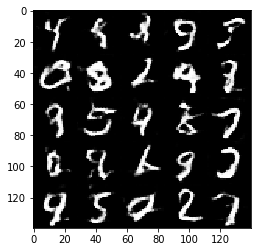

Epoch 2/2... Discriminator Loss: 1.9795... Generator Loss: 0.3145
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.0431... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 0.8389... Generator Loss: 1.1286
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 0.7629... Generator Loss: 1.3573
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.7697
Epoch 2/2... Discriminator Loss: 0.9771... Generator Loss: 1.5198
Epoch 2/2... Discriminator Loss: 1.0142... Generator Loss: 1.0085
Epoch 2/2... Discriminator Loss: 0.8942... Generator Loss: 1.2940


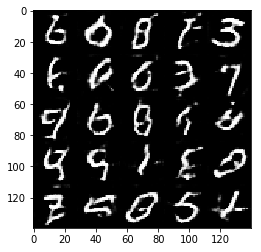

Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.0826
Epoch 2/2... Discriminator Loss: 0.8050... Generator Loss: 1.3481
Epoch 2/2... Discriminator Loss: 0.7815... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.7580
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 2.9283
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 1.2377
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.0632
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.0712


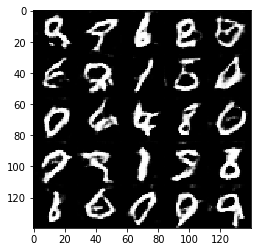

Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.1254
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 1.1740
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.5443
Epoch 2/2... Discriminator Loss: 0.9944... Generator Loss: 0.9722
Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.7502
Epoch 2/2... Discriminator Loss: 0.8866... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 0.8896... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 0.7058... Generator Loss: 1.4455


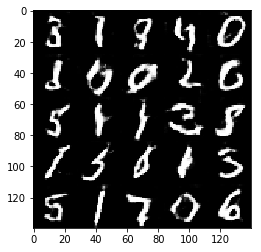

Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.8967
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.0351
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 1.8890
Epoch 2/2... Discriminator Loss: 1.6532... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.1465
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 1.5947
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.6916
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 1.0625


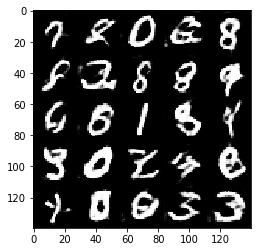

Epoch 2/2... Discriminator Loss: 0.9396... Generator Loss: 0.9454
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.9358
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 2.1284
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.7875
Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 0.7901
Epoch 2/2... Discriminator Loss: 0.8183... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 0.8557... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.4612


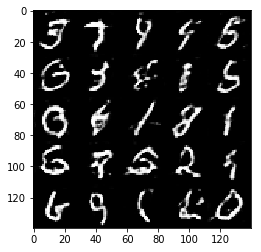

Epoch 2/2... Discriminator Loss: 0.7676... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 0.9533... Generator Loss: 2.3304
Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.2334
Epoch 2/2... Discriminator Loss: 0.8674... Generator Loss: 1.1052
Epoch 2/2... Discriminator Loss: 0.8245... Generator Loss: 1.1896
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.6464
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 2.3189
Epoch 2/2... Discriminator Loss: 0.8379... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.3591


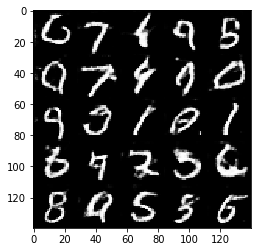

Epoch 2/2... Discriminator Loss: 0.7514... Generator Loss: 1.5484
Epoch 2/2... Discriminator Loss: 1.0934... Generator Loss: 0.8107
Epoch 2/2... Discriminator Loss: 0.9296... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.0929
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 0.9706


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.1706
Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.5306
Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 1.6143
Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 2.0979
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 2.0349
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 3.1322
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.8314


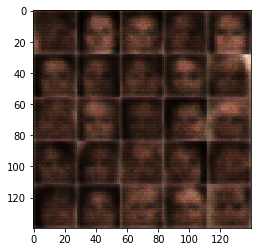

Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.5274
Epoch 1/1... Discriminator Loss: 2.4653... Generator Loss: 5.3229
Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.5295
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 0.5642... Generator Loss: 3.5097
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.1197


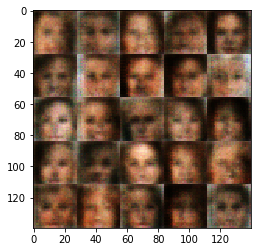

Epoch 1/1... Discriminator Loss: 2.3692... Generator Loss: 3.9526
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 2.0456
Epoch 1/1... Discriminator Loss: 1.7890... Generator Loss: 0.3051
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 1.1365
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.3230
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.1962
Epoch 1/1... Discriminator Loss: 1.6367... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.9523


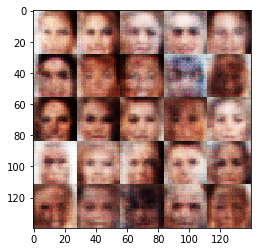

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 3.4034
Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.3738
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.7154
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6066
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.4329


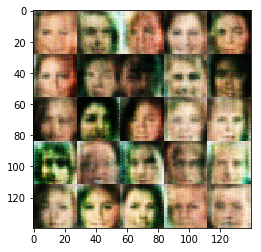

Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 2.0909... Generator Loss: 0.2457
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 0.8272... Generator Loss: 1.2295
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 2.7126
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.1233


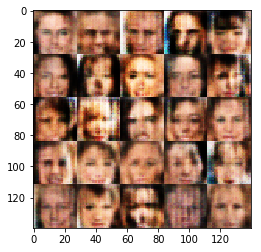

Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 0.9896
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 2.1261
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.8280... Generator Loss: 1.6943
Epoch 1/1... Discriminator Loss: 0.8522... Generator Loss: 1.6170


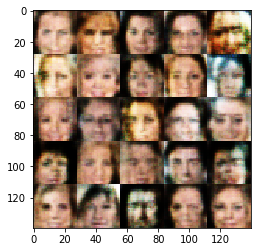

Epoch 1/1... Discriminator Loss: 1.9051... Generator Loss: 0.2852
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0580
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 2.3856
Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 1.7821


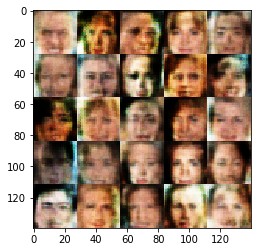

Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 1.6905
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.5534
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 1.2366... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.2337
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 4.0479


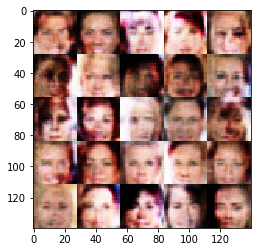

Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 1.3121
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 0.8461... Generator Loss: 1.1547
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 2.4617
Epoch 1/1... Discriminator Loss: 0.6853... Generator Loss: 1.7179
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 2.0688
Epoch 1/1... Discriminator Loss: 1.9431... Generator Loss: 0.2753


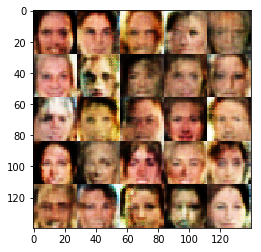

Epoch 1/1... Discriminator Loss: 0.7090... Generator Loss: 1.7971
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.8900
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 2.4028
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 0.5168... Generator Loss: 2.4432
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 2.6769
Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 1.9627
Epoch 1/1... Discriminator Loss: 0.5788... Generator Loss: 2.9209
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.8541... Generator Loss: 1.6406


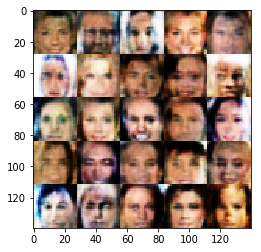

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 1.2774
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 0.9052
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 3.3227
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 2.9117
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.9864


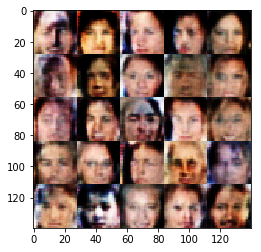

Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.2458
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2301
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.5193
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 2.3402
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 1.9167


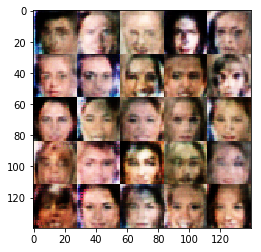

Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.8596
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 1.0383


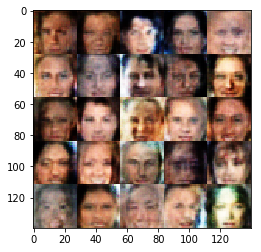

Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 1.2435... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4964... Generator Loss: 0.4888
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8791


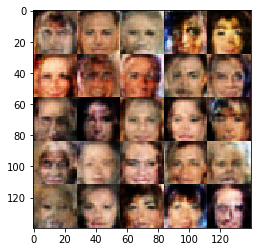

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 1.4744
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.5745
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.5178
Epoch 1/1... Discriminator Loss: 0.8022... Generator Loss: 3.7923


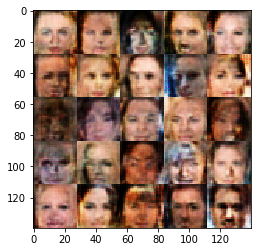

Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.4619
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 1.9011
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 2.4885... Generator Loss: 3.5580


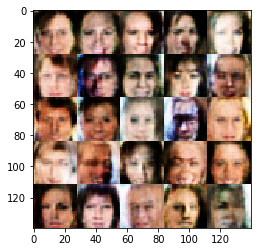

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1716
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.8701


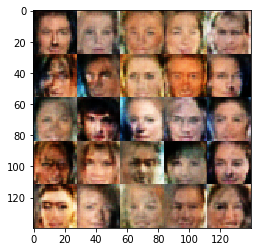

Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.1226
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.6752
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.8021


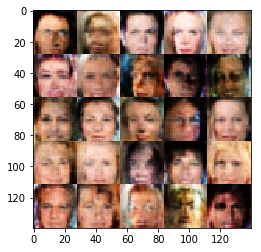

Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.1353
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.9404... Generator Loss: 0.2681
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.5948
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.4378


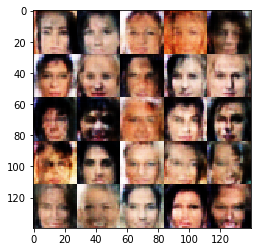

Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.7023... Generator Loss: 2.3060
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 1.9403
Epoch 1/1... Discriminator Loss: 0.9276... Generator Loss: 1.1765
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.5601
Epoch 1/1... Discriminator Loss: 1.1694... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 0.8544... Generator Loss: 2.0455


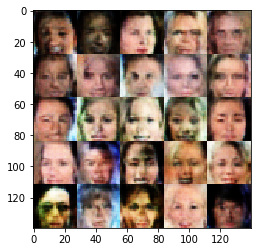

Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 1.1998
Epoch 1/1... Discriminator Loss: 0.6545... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.9365
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.5816
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.2505
Epoch 1/1... Discriminator Loss: 1.0782... Generator Loss: 1.5582
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.8968


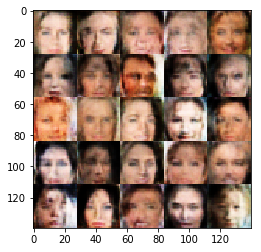

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.0200... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8368


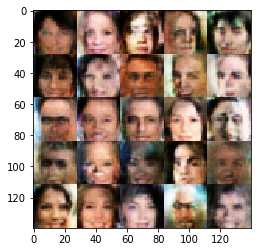

Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.3744
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.4333
Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 1.0192
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 1.0767
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.8388


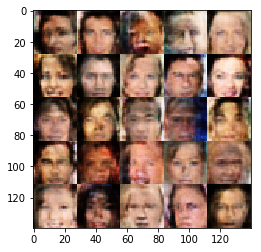

Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 0.5986... Generator Loss: 1.8391
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.6474... Generator Loss: 1.8294
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 1.2043


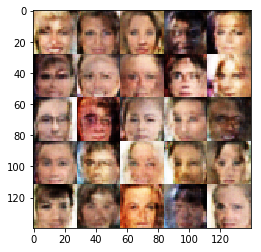

Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 1.0024... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.6955
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.3734
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 1.0028


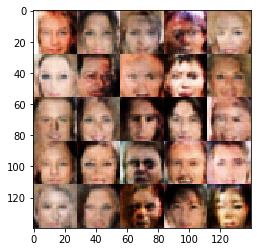

Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 1.6576
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.8625
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.6497... Generator Loss: 1.5272


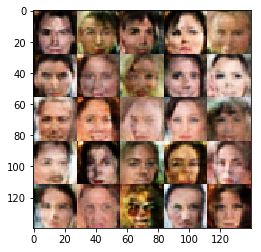

Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.2419
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 0.8181... Generator Loss: 1.6965
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6715


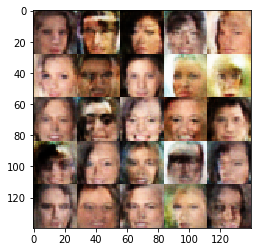

Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 1.2902
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.0501
Epoch 1/1... Discriminator Loss: 0.9200... Generator Loss: 1.6194
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 1.0822
Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 2.0717
Epoch 1/1... Discriminator Loss: 1.0291... Generator Loss: 1.0730


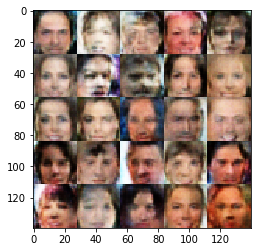

Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.2166
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.5916
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.3772
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.6131... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.6499


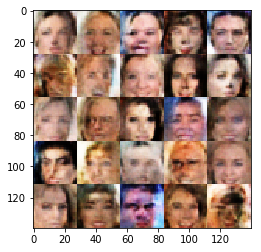

Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.1548... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 0.8104... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 2.5353
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.5467
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 1.7597


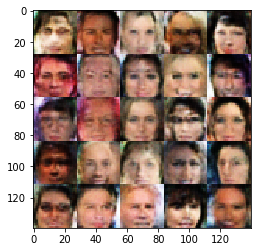

Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.5742
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.2092
Epoch 1/1... Discriminator Loss: 0.8298... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.6763


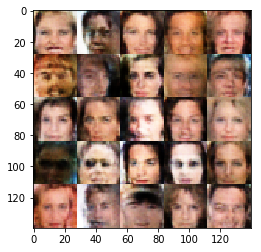

Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 2.0447
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7045


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.